In [365]:
from sklearn.datasets import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%run -i code/code.py
%matplotlib inline

Podríamos poner simplemente un umbral a una regresión lineal para convertirlo en un problema de clasificación, pero:

- tendríamos una función discontinua, lo que complica derivadas, etc.
- el problema de clasificación es fundamentalmente distinto y es fácil encontrar casos con comportamientos no deseados

usamos por tanto la función sigmoide $g(x) = \frac{1}{1+e^x}$, garantizando que $g(x) \in [0,1]$ y ponemos un umbral en 0.5

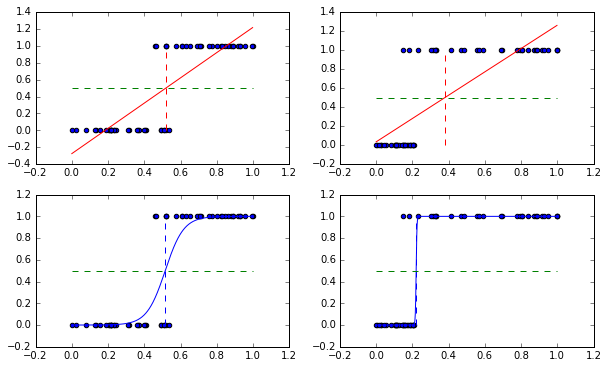

In [366]:
from IPython.display import Image
Image(filename='imgs/lrthreshold.png') 

usaremos un dataset sintético de `sklearn`

In [367]:
from sklearn.linear_model import LogisticRegression
n=200
(d,c) = make_moons(n_samples=n, noise=0.2)

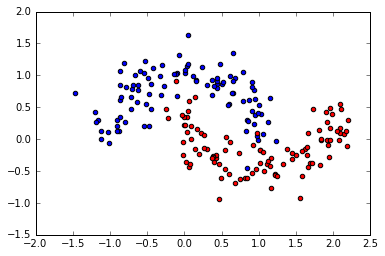

In [368]:
%run -i code/code.py
plt.scatter(d[c==0][:,0], d[c==0][:,1], c="blue")
plt.scatter(d[c==1][:,0], d[c==1][:,1], c="red")

denotamos un punto cualquiera en $\mathbb{R}^2$ por $\mathbf{x}= [1, x_1^{(i)}, x_2^{(i)}]$ (observa que le hemos añadido un 1), y está asociado a una clase $y^{(i)} \in \{0,1\}$.

**ASUMIMOS** que las clases son linealmente separables por una hiperplano parametrizado por $\theta = [\theta_0, \theta_1, \theta_2]$ a través de la siguiente función:

$$\hat{y}^{(i)} = g(\mathbf{x}^{(i)}\theta)\;\;\;\; \hat{y}^{(i)} \in [0,1]$$

con $g = \frac{1}{1+e^{-x}}$, la función sigmoide. Si $\hat{y}^{(i)}<0.5$ consideramos que la estimación clasifica el dato $x^{(i)}$ en la clase 0, y si no en la clase 1. Observa que $g$ es una función escalar: $g: \mathbb{R} \rightarrow \mathbb{R}$

queremos encontrar los valores $\theta_{min}$ que parametrizan una recta de modo que

$$ J(\theta) =  \frac{1}{m}\sum_{i=0}^{m-1} (y^{(i)}-g(\theta\mathbf{x}^{(i)}))^2$$

$$\theta_{min} = \underset{\theta}{arg\,min} \,\,\,J(\theta)$$ 

y en modo matricial, con $\mathbf{X} \in \mathbb{R}^{(m+1)\times n}$:

$$J(\theta) = \frac{1}{m}sum(g(\mathbf{X}\theta)-\mathbf{y})^2$$

asumiendo que $g$ opera en una matriz elemento a elemento.

Igualmente, el gradiente en forma matricial viene dado por:

$$\nabla J= \frac{1}{m}2X^{T}\cdot(g(X\cdot\theta)-Y)$$


Fíjate cómo resolvemos este problema de optimización con `sklearn.optimize`

In [386]:
def g(X):
    return 1/(1+np.exp(-X))

X = np.hstack((np.ones((len(d),1)), d))

def cost(t):
    return np.sum((g(X.dot(t)) - c)**2)/len(X)

def grad(t):
    return 2*X.T.dot(g(X.dot(t))-c)/len(X)

r = minimize(cost, np.zeros(X.shape[1]), jac=grad,  method="BFGS")
print r

predictions = (g(X.dot(r.x))>0.5)*1 # convert bool to [0,1] integer
print "predictions   ", predictions
print "actual classes", c

      fun: 0.09155603577150986
 hess_inv: array([[  4.63043648,  -1.37601173,  -9.33558955],
       [ -1.37601173,   3.00082193,  -2.53975604],
       [ -9.33558955,  -2.53975604,  46.10551701]])
      jac: array([ -6.72498464e-06,   2.20819207e-04,  -5.32487642e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 69
      nit: 32
     njev: 57
   status: 2
  success: False
        x: array([ 0.62652992,  1.12098747, -4.47287689])
predictions    [1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1
 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0
 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0
 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1
 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0
 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1]
actual classes [1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1
 1 0 0 0 0 0 1

Observa cómo representamos la frontera de clasificación calculada

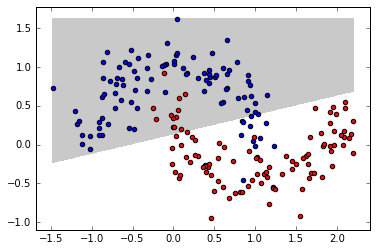

In [387]:
n = 200
d0 = np.linspace(np.min(d[:,0]), np.max(d[:,0]),n)
d1 = np.linspace(np.min(d[:,1]), np.max(d[:,1]),n)
gd0,gd1 = np.meshgrid(d0,d1)
X = np.hstack((np.ones((n**2,1)),gd0.reshape(-1,1), gd1.reshape(-1,1)))
p = ((g(X.dot(r.x))>0.5)*1.).reshape((n,n))
plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
plt.scatter(d[c==0][:,0], d[c==0][:,1], c="blue")
plt.scatter(d[c==1][:,0], d[c==1][:,1], c="red")